# Time series forecasting with DeepAR
DeepAR is a supervised learning algorithm for forecasting scalar time series. 


Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [2]:
import sagemaker


def get_execution_role(sagemaker_session=None):
    """
    Returns the role ARN whose credentials are used to call the API.
    In AWS notebook instance, this will return the ARN attributed to the
    notebook. Otherwise, it will return the ARN stored in settings
    at the project level.
    :param: sagemaker_session(Session): Current sagemaker session
    :rtype: string: the role ARN
    """
    try:
        role = sagemaker.get_execution_role(sagemaker_session=sagemaker_session)
    except ValueError as e:
        try:
            # read your role from a configuration file, from environment variables, etc. It's up to you
            from some_module_of_your_project import get_sagemaker_role_from_settings
            arn = get_sagemaker_role_from_settings()
        except ImportError as ee:
            print('Could not import module to load the role from settings')
            raise ee
        if ':role/' in arn:
            role = arn
        else:
            message = 'The current AWS identity is not a role: {},' \
                      'therefore it cannot be used ' \
                      'as a SageMaker execution role'
            raise ValueError(message.format(arn))
    return role
role = get_execution_role()  # Voila! This works everywhere

Could not import module to load the role from settings


ModuleNotFoundError: No module named 'some_module_of_your_project'

In [1]:
bucket = 'sagemaker-testtimeseries'
prefix = 'sagemaker/test-moredat'
 
# Define IAM role
import sagemaker

import sagemaker.predictor
from sagemaker.predictor import csv_serializer, json_deserializer
import boto3
import  s3fs
import re
from sagemaker import get_execution_role
import json
import math
from os import path
import sagemaker.amazon.common as smac

role = get_execution_role()


In [2]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
region = boto3.Session().region_name
smclient = boto3.Session().client('sagemaker')

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [3]:

containers  = {
    'us-west-2': '156387875391.dkr.ecr.us-west-2.amazonaws.com/forecasting-deepar:latest'
}
image_name = containers[boto3.Session().region_name]



Now we'll import the Python libraries we'll need.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import os
import time
import json
import glob

---
## Data

Let's download the data.  More information about this dataset can be found [here](https://rdrr.io/github/robjhyndman/fpp/man/gasoline.html).

In [5]:
#!wget http://gwa.ewi.tudelft.nl/fileadmin/pds/trace-archives/grid-workloads-archive/datasets/gwa-t-12/rnd.zip

In [6]:
#import zipfile
#with zipfile.ZipFile("rnd.zip","r") as zip_ref:
#    zip_ref.extractall("targetdir")

In [7]:
files = glob.glob(os.path.join('targetdir/rnd/2013-7', "*.csv"))
files_first200 = files[:300]
dfs = [pd.read_csv(fp, sep = ';\t').assign(VM=os.path.basename(fp).split('.')[0]) for fp in files_first200]
df = pd.concat(dfs, ignore_index=True)

files2 = glob.glob(os.path.join('targetdir/rnd/2013-8', "*.csv"))
files2_first200 = files2[:300]
dfs2 = [pd.read_csv(fp, sep = ';\t').assign(VM=os.path.basename(fp).split('.')[0]) for fp in files2_first200]
df2 = pd.concat(dfs2, ignore_index=True)

files3 = glob.glob(os.path.join('targetdir/rnd/2013-9', "*.csv"))
files3_first200 = files3[:300]
dfs3 = [pd.read_csv(fp, sep = ';\t').assign(VM=os.path.basename(fp).split('.')[0]) for fp in files3_first200]
df3 = pd.concat(dfs3, ignore_index=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifyin

In [8]:
newdat = df.append(df2)
newerdat = newdat.append(df3)
concatenated_df = newerdat

And take a look at it.

In [9]:
concatenated_df.head()

,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s],VM
0,1372629804,2,4799.999458,1412.799840,29.433333,16777216.0,1711274.4,0.266667,44.866667,14.333333,6.466667,413
1,1372630104,2,4799.999458,1454.399836,30.300000,16777216.0,1644165.6,0.066667,42.800000,14.866667,7.200000,413
2,1372630404,2,4799.999458,1444.799837,30.100000,16777216.0,1700089.6,0.466667,86.333333,15.466667,7.466667,413
3,1372630704,2,4799.999458,1483.199833,30.900000,16777216.0,1610611.2,0.066667,106.200000,22.133333,9.000000,413
4,1372631004,2,4799.999458,1521.599828,31.700000,16777216.0,1688904.8,0.066667,50.400000,26.400000,11.800000,413


In [10]:
concatenated_df.tail()

,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s],VM
2564395,1380490730,1,2699.998511,21.599988,0.800000,126020.0,55572.000000,0.0,0.400000,0.0,0.0,435
2564396,1380491030,1,2699.998511,21.599988,0.800000,126020.0,49455.200000,0.0,0.333333,0.0,0.0,435
2564397,1380491330,1,2699.998511,26.999985,1.000000,126020.0,54348.000000,0.0,0.466667,0.0,0.0,435
2564398,1380491630,1,2699.998511,23.399987,0.866667,126020.0,48406.666667,0.0,0.266667,0.0,0.0,435
2564399,1380491930,1,2699.998511,21.599988,0.800000,126020.0,50853.333333,0.0,0.400000,0.0,0.0,435


## Data Wrangling

In [11]:
concatenated_df['Timestamp'] = pd.to_datetime(concatenated_df['Timestamp [ms]'], unit = 's')
#concatenated_df.apply(pd.to_numeric, errors='ignore')
concatenated_df.describe()
concatenated_df['weekday'] = concatenated_df['Timestamp'].dt.dayofweek


concatenated_df['weekend'] = ((concatenated_df.weekday) // 5 == 1).astype(float)
# Feature engineering with the date
concatenated_df['month']=concatenated_df.Timestamp.dt.month 
concatenated_df['day']=concatenated_df.Timestamp.dt.day
concatenated_df.set_index('Timestamp',inplace=True)
concatenated_df["CPU usage prev"] = concatenated_df['CPU usage [%]'].shift(1)
concatenated_df["CPU_diff"] = concatenated_df['CPU usage [%]'] - concatenated_df["CPU usage prev"]
concatenated_df["received_prev"] = concatenated_df['Network received throughput [KB/s]'].shift(1)
concatenated_df["received_diff"] = concatenated_df['Network received throughput [KB/s]']- concatenated_df["received_prev"]

concatenated_df["transmitted_prev"] = concatenated_df['Network transmitted throughput [KB/s]'].shift(1)
concatenated_df["transmitted_diff"] = concatenated_df['Network transmitted throughput [KB/s]']- concatenated_df["transmitted_prev"]

In [12]:
concatenated_df["start"] = concatenated_df.index
concatenated_df['target'] = concatenated_df['CPU usage [MHZ]']

In [13]:

result = pd.concat([concatenated_df['VM'],concatenated_df['start'], concatenated_df['target']], axis=1)
result = result.reset_index()
#result.set_index('start',inplace=True)

result.set_index(['start', 'VM'],inplace=True)
result.drop('Timestamp', axis=1, inplace=True)


In [14]:
df2 = concatenated_df.groupby('VM').resample('1min', how={'target':np.mean})

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:1502: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  return get_resampler_for_grouping(self, rule, *args, **kwargs)


In [15]:
df3 = concatenated_df.groupby('VM').resample('1min', how={'CPU capacity provisioned [MHZ]':np.mean})
df3.reset_index(level=0, inplace=True)
df3 = df3.fillna(method='ffill')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:1502: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  return get_resampler_for_grouping(self, rule, *args, **kwargs)


In [16]:
df2.reset_index(level=0, inplace=True)

In [17]:
df2 = df2.fillna(method='ffill')

In [18]:
#df2.to_csv("df2.csv", sep = ',')
#concatenated_df.to_csv("concatenated_df.csv", sep = ',')

## Format data into json 


In [19]:
freq = "1min"
context_length = 30
prediction_length = 30

In [20]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [ ]:
time_series_test=[]
vm_index_range = df2['VM'].unique()
for i in vm_index_range:
    newseries = df2[df2['VM'] == i]['target']
    del newseries.index.name
    newseries.index = pd.to_datetime(newseries.index)
    time_series_test.append(newseries)
    #time_series_test = time_series_test.fillna(0)


In [ ]:
time_series_training=[]
vm_index_range = df2['VM'].unique()
for i in vm_index_range:
    newseries = df2[df2['VM'] == i]['target']
    del newseries.index.name
    newseries.index = pd.to_datetime(newseries.index)
    time_series_training.append(newseries[:-prediction_length])
    #time_series_training = time_series_training.fillna(0)
    


## Push the json files to S3 bucket

In [ ]:
s3filesystem = s3fs.S3FileSystem()

In [67]:
encoding = "utf-8"

with s3filesystem.open(s3_data_path + "/test/test_data.json", 'wb') as fp:
    for ts in time_series_test:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding)) 

In [79]:
with s3filesystem.open(s3_data_path + "/train/train_data.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding)) 

## Set hyperparameters
### sagemaker automatically adds lags, so context length can be shorter than seasons

In [ ]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='test-demo-deepar',
    output_path="s3://" + s3_output_path
)

In [ ]:
hyperparameters  = {
    "time_freq": freq,
    "context_length": context_length,
    "prediction_length": prediction_length,
    "num_cells": "32",
    "num_layers": "2",
    "likelihood": "student-t",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [ ]:
estimator.set_hyperparameters(**hyperparameters)

## Train model

In [ ]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

## Create endpoint and predictor
Now that we have trained a model, we can use it to perform predictions by deploying it to an endpoint.

Note: remember to delete the enpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.

In [ ]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

In [ ]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [ ]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

## Visualize Model Predictions

In [ ]:
new_time_series_training = []
for ts in time_series_training:
    new_time_series_training.append(ts.asfreq('T'))

In [ ]:
new_time_series_test = []
for ts in time_series_test:
    new_time_series_test.append(ts.asfreq('T'))

In [ ]:
# 2 max for memory (on my desktop)
list_of_df  = predictor.predict(new_time_series_training[1:2]) # predicted forecast
actual_data = new_time_series_test[1:2] # full data set

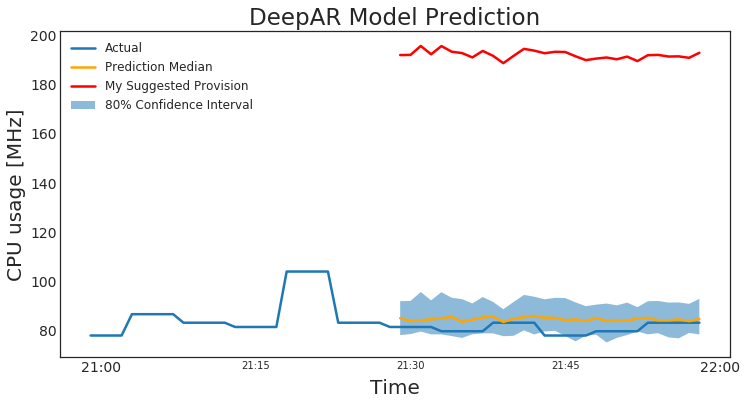

In [275]:
for k in range(len(list_of_df)): 
    plt.style.use('seaborn-white')
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='Actual',linewidth = 2.5)
    p10 = list_of_df[k]['0.1'] 
    p90 = list_of_df[k]['0.9'] #set limits predictively
    plt.fill_between(p10.index, p10, p90, alpha=0.5, label='80% Confidence Interval')
    list_of_df[k]['0.5'].plot(label='Prediction Median', color = 'orange',linewidth = 2.5) # set requests for capacity allocation 
    #(list_of_df[k]['0.9']+50).plot(label='My Suggested Provision', color = 'r',linewidth = 2.5) # set requests for capacity allocation 
    plt.title("DeepAR Model Prediction", fontsize = 23)
    plt.ylabel("CPU usage [MHz]", fontsize = 20)
    #plt.yticks([10,20.40,50])
    plt.xlabel("Time", fontsize = 20)
    (list_of_df[k]['0.9']+100).plot(label='My Suggested Provision', color = 'r',linewidth = 2.5) # set requests for capacity allocation 
    plt.yticks(fontsize=14);
    #plt.axhline(y=5851.99912, color='g', linestyle='-', label = 'Actual Provision')
    plt.xticks(fontsize=14);
    plt.legend(fontsize = 12,loc = 'best')
    plt.savefig('VM101')
    plt.show()


In [276]:
vm101_p90 = pd.DataFrame(p90)
vm101_p90['VM'] = '101'
vm101_p90['my_lim'] = list_of_df[k]['0.9']+100
vm101_p90['actual'] = pd.DataFrame(df3['CPU capacity provisioned [MHZ]'][(df3.index > '2013-09-29 21:29:00') & (df3.VM == '101')])
vm101_p90['percent'] = (vm101_p90['my_lim']/vm101_p90['actual'])*100
vm101_p90.to_csv('vm1_p90.csv', sep = ',')
vm101_p90

,0.9,VM,my_lim,actual,percent
2013-09-29 21:29:00,91.980888,101,191.980888,NaN,NaN
2013-09-29 21:30:00,92.043060,101,192.043060,5199.99862,3.693137
2013-09-29 21:31:00,95.678757,101,195.678757,5199.99862,3.763054
2013-09-29 21:32:00,92.288063,101,192.288063,5199.99862,3.697848
2013-09-29 21:33:00,95.632141,101,195.632141,5199.99862,3.762158
2013-09-29 21:34:00,93.333878,101,193.333878,5199.99862,3.717960
2013-09-29 21:35:00,92.793739,101,192.793739,5199.99862,3.707573
2013-09-29 21:36:00,91.027672,101,191.027672,5199.99862,3.673610
2013-09-29 21:37:00,93.654350,101,193.654350,5199.99862,3.724123
2013-09-29 21:38:00,91.677498,101,191.677498,5199.99862,3.686107


In [277]:
# 2 max for memory (on my desktop)
list_of_df  = predictor.predict(new_time_series_training[:1]) # predicted forecast
actual_data = new_time_series_test[:1] # full data set

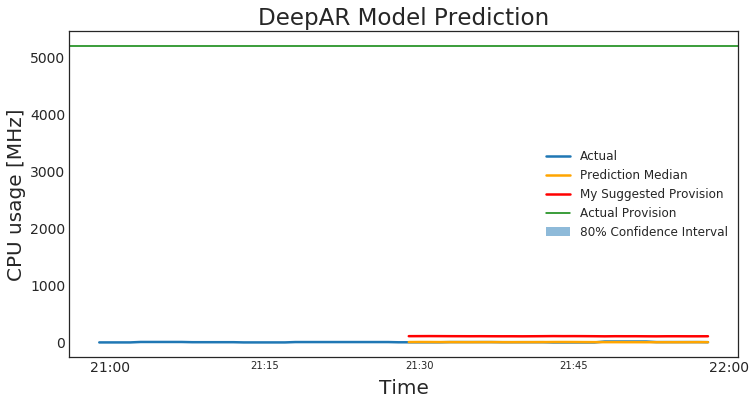

In [278]:
for k in range(len(list_of_df)): 
    plt.style.use('seaborn-white')
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='Actual',linewidth = 2.5)
    p10 = list_of_df[k]['0.1'] 
    p90 = list_of_df[k]['0.9'] #set limits predictively
    plt.fill_between(p10.index, p10, p90, alpha=0.5, label='80% Confidence Interval')
    list_of_df[k]['0.5'].plot(label='Prediction Median', color = 'orange',linewidth = 2.5) # set requests for capacity allocation 
    (list_of_df[k]['0.9']+100).plot(label='My Suggested Provision', color = 'r',linewidth = 2.5) # set requests for capacity allocation 
    plt.title("DeepAR Model Prediction", fontsize = 23)
    plt.ylabel("CPU usage [MHz]", fontsize = 20)
    #plt.yticks([50,100,150])
    plt.xlabel("Time", fontsize = 20)
    plt.yticks(fontsize=14);
    plt.axhline(y=5199.99862, color='g', linestyle='-', label = 'Actual Provision')
    plt.xticks(fontsize=14);
    plt.legend(fontsize = 12)
    plt.savefig('VM1')
    plt.show()


In [272]:
vm1_p90 = pd.DataFrame(p90)
vm1_p90['VM'] = '1'
vm1_p90['my_lim'] = list_of_df[k]['0.9']+100
vm1_p90['actual'] = pd.DataFrame(df3['CPU capacity provisioned [MHZ]'][(df3.index > '2013-09-29 21:29:00') & (df3.VM == '1')])
vm1_p90['percent'] = (vm1_p90['my_lim']/vm1_p90['actual'])*100
vm1_p90.to_csv('vm1_p90.csv', sep = ',')
vm1_p90

,0.9,VM,my_lim,actual,percent
2013-09-29 21:29:00,10.557265,1,110.557265,NaN,NaN
2013-09-29 21:30:00,9.683583,1,109.683583,5851.99912,1.874293
2013-09-29 21:31:00,10.142719,1,110.142719,5851.99912,1.882138
2013-09-29 21:32:00,10.170185,1,110.170185,5851.99912,1.882608
2013-09-29 21:33:00,8.427563,1,108.427563,5851.99912,1.852829
2013-09-29 21:34:00,7.984614,1,107.984614,5851.99912,1.845260
2013-09-29 21:35:00,8.466341,1,108.466341,5851.99912,1.853492
2013-09-29 21:36:00,8.534096,1,108.534096,5851.99912,1.854650
2013-09-29 21:37:00,8.239283,1,108.239283,5851.99912,1.849612
2013-09-29 21:38:00,6.876278,1,106.876278,5851.99912,1.826321


In [219]:
# 2 max for memory (on my desktop)
list_of_df  = predictor.predict(new_time_series_training[2:3]) # predicted forecast
actual_data = new_time_series_test[2:3] # full data set

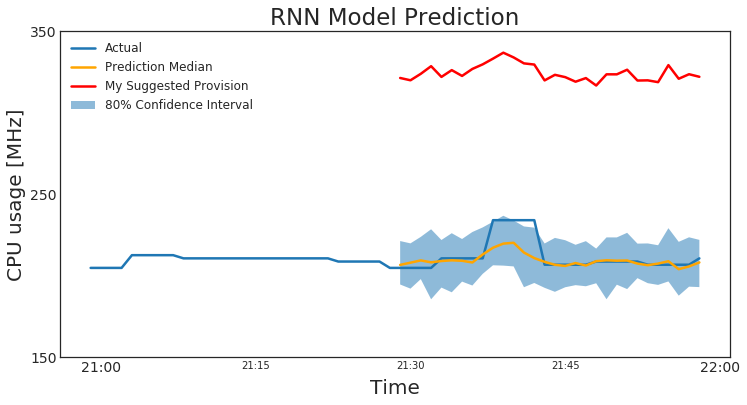

In [221]:
for k in range(len(list_of_df)): 
    plt.style.use('seaborn-white')
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='Actual',linewidth = 2.5)
    p10 = list_of_df[k]['0.1'] 
    p90 = list_of_df[k]['0.9'] #set limits predictively
    plt.fill_between(p10.index, p10, p90, alpha=0.5, label='80% Confidence Interval')
    list_of_df[k]['0.5'].plot(label='Prediction Median', color = 'orange',linewidth = 2.5) # set requests for capacity allocation 
    (list_of_df[k]['0.9']+100).plot(label='My Suggested Provision', color = 'r',linewidth = 2.5) # set requests for capacity allocation 
    plt.title("RNN Model Prediction", fontsize = 23)
    plt.ylabel("CPU usage [MHz]", fontsize = 20)
    plt.yticks([150,250,350])
    plt.xlabel("Time", fontsize = 20)
    plt.yticks(fontsize=14);
    #plt.axhline(y=2599.999299, color='g', linestyle='-', label = 'Actual Provision')
    plt.xticks(fontsize=14);
    plt.legend(fontsize = 12)
    plt.savefig('VM103')
    plt.show()

In [223]:
vm103_p90 = pd.DataFrame(p90)
vm103_p90['VM'] = '103'
vm103_p90['my_lim'] = list_of_df[k]['0.9']+100
vm103_p90['actual'] = pd.DataFrame(df3['CPU capacity provisioned [MHZ]'][(df3.index > '2013-09-29 21:29:00') & (df3.VM == '103')])
vm103_p90['percent'] = (vm103_p90['my_lim']/vm103_p90['actual'])*100
vm103_p90.to_csv('vm103_p90.csv', sep = ',')
vm103_p90

,0.9,VM,my_lim,actual,percent
2013-09-29 21:29:00,221.282471,103,321.282471,NaN,NaN
2013-09-29 21:30:00,219.864639,103,319.864639,11703.99914,2.732952
2013-09-29 21:31:00,223.840240,103,323.840240,11703.99914,2.766920
2013-09-29 21:32:00,228.509018,103,328.509018,11703.99914,2.806810
2013-09-29 21:33:00,221.931198,103,321.931198,11703.99914,2.750609
2013-09-29 21:34:00,226.093658,103,326.093658,11703.99914,2.786173
2013-09-29 21:35:00,222.536407,103,322.536407,11703.99914,2.755779
2013-09-29 21:36:00,226.828278,103,326.828278,11703.99914,2.792450
2013-09-29 21:37:00,229.633179,103,329.633179,11703.99914,2.816415
2013-09-29 21:38:00,233.138367,103,333.138367,11703.99914,2.846364


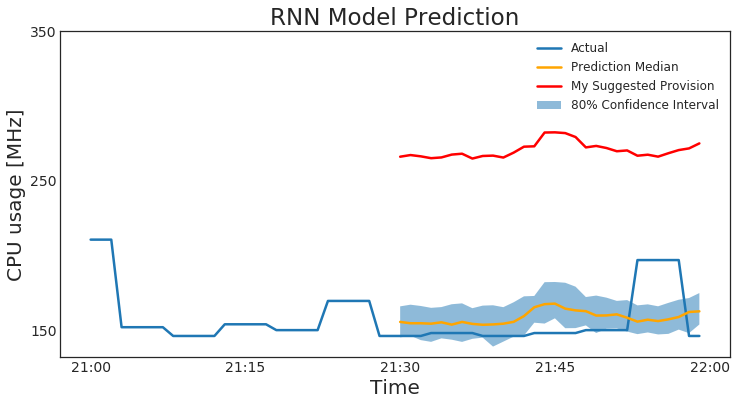

In [355]:
# 2 max for memory (on my desktop)
list_of_df  = predictor.predict(new_time_series_training[3:4]) # predicted forecast
actual_data = new_time_series_test[3:4] # full data set

for k in range(len(list_of_df)): 
    plt.style.use('seaborn-white')
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='Actual',linewidth = 2.5)
    p10 = list_of_df[k]['0.1'] 
    p90 = list_of_df[k]['0.9'] #set limits predictively
    plt.fill_between(p10.index, p10, p90, alpha=0.5, label='80% Confidence Interval')
    list_of_df[k]['0.5'].plot(label='Prediction Median', color = 'orange',linewidth = 2.5) # set requests for capacity allocation 
    (list_of_df[k]['0.9']+100).plot(label='My Suggested Provision', color = 'r',linewidth = 2.5) # set requests for capacity allocation 
    plt.title("RNN Model Prediction", fontsize = 23)
    plt.ylabel("CPU usage [MHz]", fontsize = 20)
    plt.yticks([150,250,350])
    plt.xlabel("Time", fontsize = 20)
    plt.yticks(fontsize=14);
    plt.xticks(fontsize=14);
    plt.legend(fontsize = 12)
    plt.savefig('VM106')
    plt.show()

In [357]:
vm106_p90 = pd.DataFrame(p90)
vm106_p90['VM'] = '106'
vm106_p90['my_lim'] = list_of_df[k]['0.9']+100
vm106_p90['actual'] = pd.DataFrame(df3['CPU capacity provisioned [MHZ]'][(df3.index > '2013-09-29 21:29:00') & (df3.VM == '106')])
vm106_p90['usage'] = actual_data[k][-prediction_length-context_length:]
vm106_p90['percent'] = (vm106_p90['my_lim']/vm106_p90['actual'])*100
vm106_p90.to_csv('vm106_p90.csv', sep = ',')
vm106_p90.describe()

,0.9,my_lim,actual,usage,percent
count,30.000000,30.000000,3.000000e+01,30.000000,30.000000
mean,170.448170,270.448170,1.170400e+04,156.053297,2.310733
std,5.193637,5.193637,1.850085e-12,18.682061,0.044375
min,164.853638,264.853638,1.170400e+04,146.299966,2.262933
25%,166.619926,266.619926,1.170400e+04,146.299966,2.278025
50%,168.616943,268.616943,1.170400e+04,148.250632,2.295087
75%,172.667446,272.667446,1.170400e+04,150.201299,2.329695
max,182.370514,282.370514,1.170400e+04,197.017288,2.412599


In [358]:
1.170400e+04

11704.0

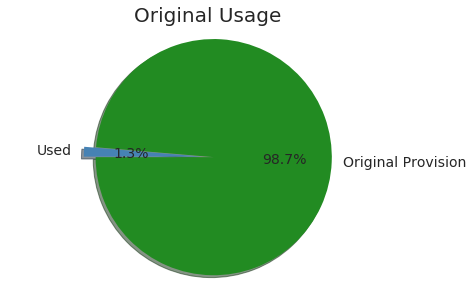

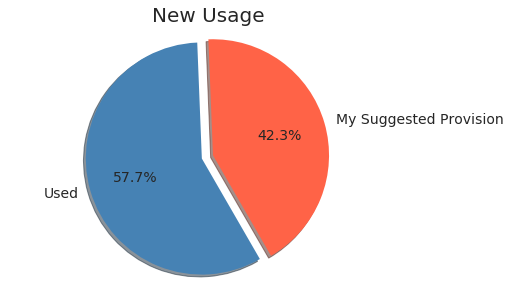

In [373]:
import matplotlib.pyplot as plt

# Pie chart
labels = ['Original Provision', 'Used']
sizes = [100-(156.053/(11704.0)*100), (156.053/(11704.0)*100)]
explode = (0, 0.1)
#add colors
plt.rcParams['font.size'] = 14
colors = ['forestgreen','steelblue']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=180)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
plt.title('Original Usage',fontsize = 20)
plt.show()

import matplotlib.pyplot as plt

# Pie chart
labels = ['My Suggested Provision', 'Used']
sizes = [100-(156.053/(270.449)*100), (156.053/(270.449)*100)]
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0, 0.1)
#add colors
colors = ['tomato','steelblue']
plt.rcParams['font.size'] = 14
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=300)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
plt.title('New Usage', fontsize = 20)
plt.show()

In [289]:
# 2 max for memory (on my desktop)
list_of_df  = predictor.predict(new_time_series_training[295:296]) # predicted forecast
actual_data = new_time_series_test[295:296] # full data set

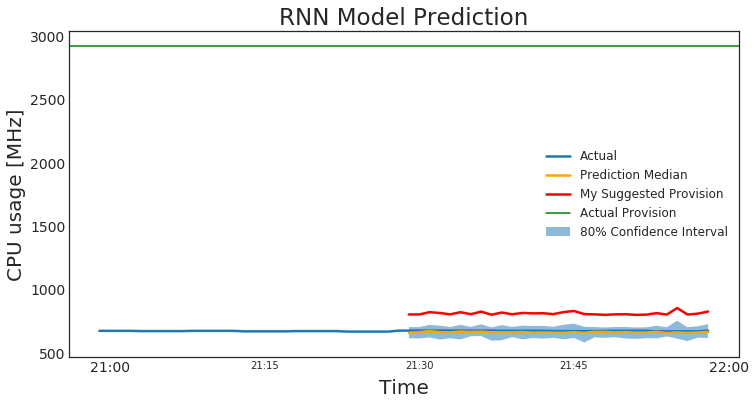

In [290]:

for k in range(len(list_of_df)): 
    plt.style.use('seaborn-white')
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='Actual',linewidth = 2.5)
    p10 = list_of_df[k]['0.1'] 
    p90 = list_of_df[k]['0.9'] #set limits predictively
    plt.fill_between(p10.index, p10, p90, alpha=0.5, label='80% Confidence Interval')
    list_of_df[k]['0.5'].plot(label='Prediction Median', color = 'orange',linewidth = 2.5) # set requests for capacity allocation 
    (list_of_df[k]['0.9']+100).plot(label='My Suggested Provision', color = 'r',linewidth = 2.5) # set requests for capacity allocation 
    plt.title("RNN Model Prediction", fontsize = 23)
    plt.ylabel("CPU usage [MHz]", fontsize = 20)
    #plt.yticks([150,250,350])
    plt.xlabel("Time", fontsize = 20)
    plt.yticks(fontsize=14);
    plt.axhline(y=2925.999338, color='g', linestyle='-', label = 'Actual Provision')
    plt.xticks(fontsize=14);
    plt.legend(fontsize = 12)
    plt.savefig('VM9-w-actual')
    plt.show()

In [307]:
vm9_p90 = pd.DataFrame(p90)
vm9_p90['VM'] = '9'
vm9_p90['my_lim'] = list_of_df[k]['0.9']+100
vm9_p90['usage'] = actual_data[k][-prediction_length-context_length:]
vm9_p90['actual'] = pd.DataFrame(df3['CPU capacity provisioned [MHZ]'][(df3.index > '2013-09-29 21:29:00') & (df3.VM == '9')])
vm9_p90['percent'] = (vm9_p90['my_lim']/vm9_p90['actual'])*100
vm9_p90.to_csv('vm9_p90.csv', sep = ',')
vm9_p90.describe()

,0.9,my_lim,usage,actual,percent
count,30.000000,30.000000,30.000000,2.900000e+01,29.000000
mean,712.998429,812.998429,674.605403,2.925999e+03,27.795317
std,11.887614,11.887614,2.117314,4.627966e-13,0.409698
min,701.312073,801.312073,671.029182,2.925999e+03,27.385928
25%,704.761108,804.761108,672.979848,2.925999e+03,27.516351
50%,707.268097,807.268097,674.930514,2.925999e+03,27.589647
75%,719.034409,819.034409,676.881180,2.925999e+03,28.019642
max,755.329102,855.329102,676.881180,2.925999e+03,29.232033


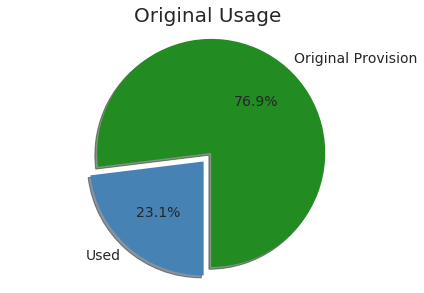

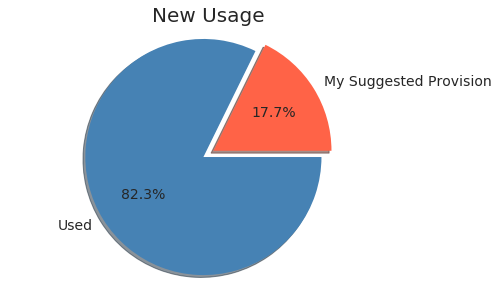

In [354]:
import matplotlib.pyplot as plt

# Pie chart
labels = ['Original Provision', 'Used']
sizes = [100-(674.605/(2925.99)*100), (674.605/(2925.99)*100)]
explode = (0, 0.1)
#add colors
plt.rcParams['font.size'] = 14
colors = ['forestgreen','steelblue']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=270)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
plt.title('Original Usage',fontsize = 20)
plt.show()

import matplotlib.pyplot as plt

# Pie chart
labels = ['My Suggested Provision', 'Used']
sizes = [100-(674.605/(819.998)*100), (674.605/(819.998)*100)]
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0, 0.1)
#add colors
colors = ['tomato','steelblue']
plt.rcParams['font.size'] = 14
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=0)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
plt.title('New Usage', fontsize = 20)
plt.show()

In [295]:
#pd.DataFrame(df2['VM'].unique())

In [243]:
#uniquevm[250:300]

In [301]:
concatenated_df['CPU usage [%]'][(concatenated_df.VM == '9') &( concatenated_df.index > '2013-09-29 21:29:00' )].mean()

23.055555555555554